In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Define file paths
BASE_DIR = '/content/drive/MyDrive'  # Update this to your Google Drive or local directory
TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')
VALID_CSV = os.path.join(BASE_DIR, 'valid.csv')
TEST_CSV = os.path.join(BASE_DIR, 'test.csv')
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR, 'train_images')
VAL_IMAGES_DIR = os.path.join(BASE_DIR, 'val_images')
TEST_IMAGES_DIR = os.path.join(BASE_DIR, 'test_images')

In [3]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VALID_CSV)
test_df = pd.read_csv(TEST_CSV)


In [4]:
# Convert diagnosis column to strings (for categorical mode compatibility)
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)
test_df['diagnosis'] = test_df['diagnosis'].astype(str)


In [5]:
# Add full file paths to the dataframes
train_df['file_path'] = train_df['id_code'].apply(lambda x: os.path.join(TRAIN_IMAGES_DIR, f"{x}.png"))
val_df['file_path'] = val_df['id_code'].apply(lambda x: os.path.join(VAL_IMAGES_DIR, f"{x}.png"))
test_df['file_path'] = test_df['id_code'].apply(lambda x: os.path.join(TEST_IMAGES_DIR, f"{x}.png"))


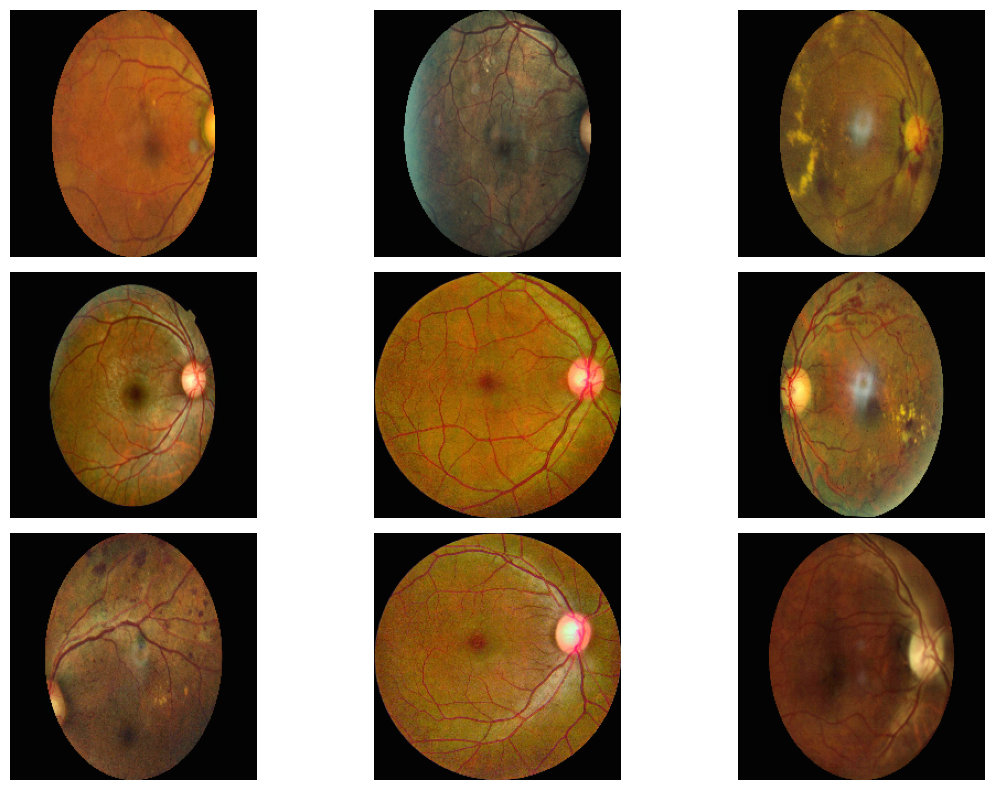

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_fundus_image(image_path, target_size=(224, 224)):
    """
    Preprocess a fundus image: crop to the circular ROI, enhance contrast,
    and resize for the model.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply a circular mask to crop the eye
    h, w = gray.shape
    mask = np.zeros_like(gray)
    center = (w // 2, h // 2)
    radius = min(h, w) // 2
    cv2.circle(mask, center, radius, 255, -1)
    cropped = cv2.bitwise_and(image, image, mask=mask)

    # Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for i in range(3):  # Apply CLAHE to each channel
        cropped[:, :, i] = clahe.apply(cropped[:, :, i])

    # Resize to target size
    resized = cv2.resize(cropped, target_size)

    return resized

def display_preprocessed_images(image_paths, target_size=(224, 224)):
    """
    Display preprocessed fundus images.
    """
    plt.figure(figsize=(12, 8))
    for i, image_path in enumerate(image_paths[:9]):  # Display first 9 images
        preprocessed = preprocess_fundus_image(image_path, target_size)
        plt.subplot(3, 3, i + 1)
        plt.imshow(preprocessed)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
sample_image_paths = train_df['file_path'].iloc[:9]  # Get a few sample image paths
display_preprocessed_images(sample_image_paths)


In [7]:
# Image size, batch size, and number of classes
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5  # Update based on dataset

# EfficientNet preprocessing function
preprocessing_fn = tf.keras.applications.efficientnet.preprocess_input

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_fn,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_fn)


In [8]:
# Create data generators
def create_generator(dataframe, datagen, x_col, y_col, shuffle=True):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle
    )

train_data = create_generator(train_df, train_datagen, x_col='file_path', y_col='diagnosis')
valid_data = create_generator(val_df, valid_test_datagen, x_col='file_path', y_col='diagnosis')
test_data = create_generator(test_df, valid_test_datagen, x_col='file_path', y_col='diagnosis', shuffle=False)


Found 2930 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


In [9]:
# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
log_dir = "./logs"  # TensorBoard logs directory
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 1522s 15s/step - accuracy: 0.6477 - loss: 1.1591 - val_accuracy: 0.7186 - val_loss: 0.9188 - learning_rate: 0.0010
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 879s 9s/step - accuracy: 0.7046 - loss: 0.9871 - val_accuracy: 0.7514 - val_loss: 0.8892 - learning_rate: 0.0010
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 814s 8s/step - accuracy: 0.7435 - loss: 0.9121 - val_accuracy: 0.7623 - val_loss: 0.9356 - learning_rate: 0.0010
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 913s 9s/step - accuracy: 0.7497 - loss: 0.9210 - val_accuracy: 0.7678 - val_loss: 0.8781 - learning_rate: 0.0010
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 801s 8s/step - accuracy: 0.7571 - loss: 0.8991 - val_accuracy: 0.7678 - val_loss: 0.8871 - learning_rate: 0.0010
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 814s 8s/step - accuracy: 0.7719 - loss: 0.8774 - val_accuracy: 0.7732 - val_loss: 0.8675 - learning_rate: 0.0010
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 856s 8s/step - accuracy: 0.7689 - loss: 0.8802 - val_accuracy: 0.

In [ ]:
# Fine-tune the model
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Fine-tune training
history_fine = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1693s 17s/step - accuracy: 0.6555 - loss: 1.1172 - val_accuracy: 0.6393 - val_loss: 1.0663 - learning_rate: 1.0000e-05
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1593s 17s/step - accuracy: 0.6515 - loss: 1.1077 - val_accuracy: 0.6885 - val_loss: 0.9975 - learning_rate: 1.0000e-05
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1595s 17s/step - accuracy: 0.6736 - loss: 1.0650 - val_accuracy: 0.6967 - val_loss: 0.9598 - learning_rate: 1.0000e-05
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1655s 17s/step - accuracy: 0.6990 - loss: 1.0213 - val_accuracy: 0.7131 - val_loss: 0.9495 - learning_rate: 1.0000e-05
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1643s 17s/step - accuracy: 0.7205 - loss: 0.9803 - val_accuracy: 0.7240 - val_loss: 0.9366 - learning_rate: 1.0000e-05


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



12/12 ━━━━━━━━━━━━━━━━━━━━ 150s 12s/step


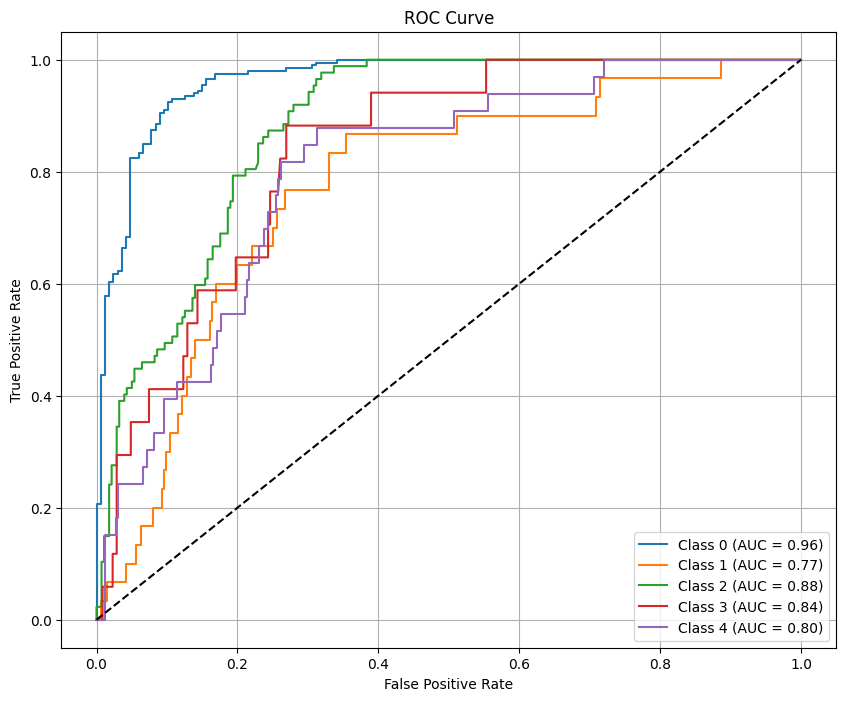

In [ ]:
# Predict probabilities for the test set
y_prob = model.predict(test_data)
y_true = test_data.classes  # Ground truth labels
class_labels = list(test_data.class_indices.keys())  # Class names

# One-hot encode true labels
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_labels))

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


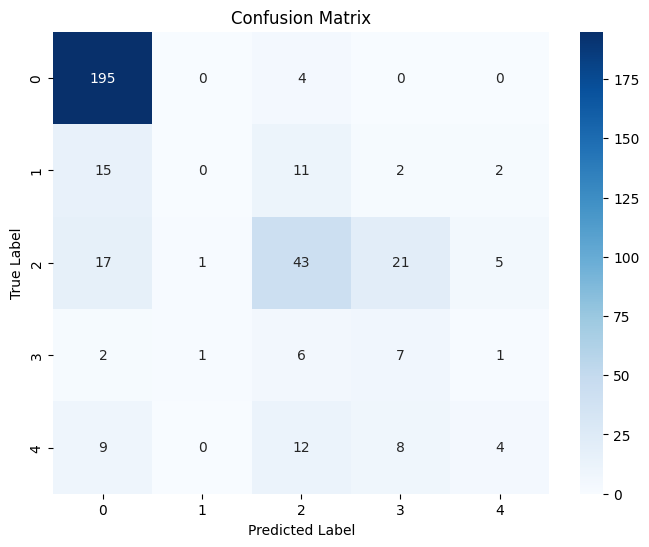

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       199
           1       0.00      0.00      0.00        30
           2       0.57      0.49      0.53        87
           3       0.18      0.41      0.25        17
           4       0.33      0.12      0.18        33

    accuracy                           0.68       366
   macro avg       0.38      0.40      0.37       366
weighted avg       0.62      0.68      0.64       366



In [ ]:
# Predict classes for the test set
y_pred = np.argmax(y_prob, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))
